# Generate a spectrogram from a file
Do imports first

In [52]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
# to enable zooming in matplotlib in notebook
#%matplotlib notebook
#conda install -c conda-forge ipympl # or pip install ipympl #This is to allow zooming in the notebook
#matplotlib ipympl
import tensorflow as tf     #pip install tensorflow
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Name audio and annotation file that you want to import (without the extensions), then read in the audio and annotations

In [53]:
#File index
file =  '5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file =  'Rupes A and B\\5713.210809120002'  #from PPT at time 892-896 (Rupe B)
#file = 'Guttural rupe\\5711.211013040024'
#file = 'Rupes A and B\\5713.210825190002'
#file =          'Moan\\5713.210902110002'  #from PPT at time 212 seconds

#Read the 2 files
sample_rate, samples = wavfile.read(file+'.wav')
annot_file_path = file +'.Table.1.selections.txt'

#Read the file into a DataFrame
df = pd.read_csv(file +'.Table.1.selections.txt', sep='\t')

#Display the first few rows of the DataFrame
print(df.head())


   Selection           View  Channel  Begin Time (s)  End Time (s)  \
0          1  Spectrogram 1        1      871.984579    872.045877   
1          2  Spectrogram 1        1      872.605082    872.730809   
2          3  Spectrogram 1        1      873.525329    873.616653   
3          4  Spectrogram 1        1      874.776471    874.904325   
4          5  Spectrogram 1        1      876.693356    876.876005   

   Low Freq (Hz)  High Freq (Hz)  Delta Time (s)  Delta Freq (Hz)  \
0         75.224         426.862          0.0613          351.638   
1         42.314         470.151          0.1257          427.837   
2         65.821         493.658          0.0913          427.837   
3         70.523         441.942          0.1279          371.419   
4         47.015         413.733          0.1826          366.718   

   Avg Power Density (dB FS/Hz) Annotation  
0                        -97.26     Rupe A  
1                        -84.86     Rupe A  
2                        -90.

<ipython-input-53-d1b487c440bc>:9: WavFileWarning: Reached EOF prematurely; finished at 220200960 bytes, expected 230395468 bytes from header.
  sample_rate, samples = wavfile.read(file+'.wav')


# Calculate the Spectrogram

In [54]:
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nperseg=2456, nfft=4096, noverlap=1228, window='hann')       #Try nfft=8192 if computer permits

With the resultsing spectrogram, trim all the tiny values so that log scale displays correctly. Also, all of the relevant info is below 1KHz so trim the data to only display sub 1-KHz frequencies

In [55]:
spectrogram[spectrogram < 0.001] = 0.001    #Trim off all the tiny values so that log scale displays correctly

#Trim in frequency
fmin = 20 # Hz
fmax = 1000 # Hz
freq_slice = np.where((frequencies >= fmin) & (frequencies <= fmax))

#keep only frequencies of interest
frequencies = frequencies[freq_slice]
spectrogram = spectrogram[freq_slice,:][0]

Next I'm going to define a dunction that will overlay the annotated rectangles onto the spectrogram (different colours for each call)

In [56]:
def overlay_annotations(ax, df, annotation_colors):
    #Track labels to ensure they are added only once in the legend
    added_labels = set()

    for _, row in df.iterrows():
        start_time = row['Begin Time (s)']
        end_time = row['End Time (s)']
        low_freq = row['Low Freq (Hz)']
        high_freq = row['High Freq (Hz)']
        annotation = row['Annotation']

        #Skip if the annotation is not in the defined colors
        if annotation not in annotation_colors:
            continue

        #Draw rectangles
        ax.add_patch(
            plt.Rectangle(
                (start_time, low_freq),  #Bottom Left corner
                end_time - start_time,  #Width (time)
                high_freq - low_freq,  #Height (frequency)
                edgecolor=annotation_colors[annotation],
                facecolor='none',
                linewidth=2,
                label=annotation if annotation not in added_labels else None  #Add label once
            )
        )
        added_labels.add(annotation)  #Mark label as added

    ax.legend(loc='upper right')     #Add legend

I've also written a function below that updates the colormap when you zoom in on a particular region - so that the max and min values are always visible

In [57]:
def update_colormap(event):
    #Get current view limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    #Find indices corresponding to the current view limits
    x_indices = np.where((times >= xlim[0]) & (times <= xlim[1]))[0]
    y_indices = np.where((frequencies >= ylim[0]) & (frequencies <= ylim[1]))[0]

    #Handle cases where no data is visible
    if len(x_indices) == 0 or len(y_indices) == 0:
        return

    #Extract the visible data
    data_visible = spectrogram[np.ix_(y_indices, x_indices)]
    #data_visible = np.log(spectrogram)[np.ix_(y_indices, x_indices)]

    #Compute new color limits
    vmin = np.nanmin(data_visible)
    vmax = np.nanmax(data_visible)

    #Update the color limits of the pcolormesh
    pc.set_clim(vmin=vmin, vmax=vmax)

    #Update the colorbar to reflect the new color limits
    cbar.update_normal(pc)

    #Redraw the figure
    plt.draw()


Ok, let's plot the spectrogram and annotations

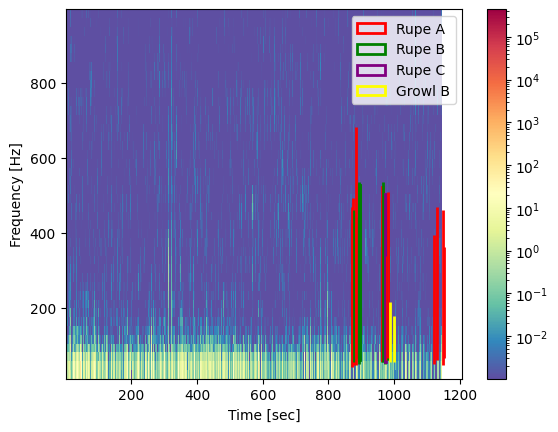

In [58]:
#Define colors for annotations
annotation_colors = {
    "Rupe A": "red",
    "Rupe B": "green",
    "Growl B": "yellow",
    "Rupe C" : "purple",
    "Moan": "pink",
    "G rupe" : "blue"
}

pc = plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
#pc = plt.pcolormesh(times, frequencies, np.log(spectrogram))
cbar = plt.colorbar(pc)
#plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

#Get the current axes
ax = plt.gca()
overlay_annotations(ax, df, annotation_colors)

#Connect the update function to the axes limit change events
ax.callbacks.connect('xlim_changed', update_colormap)
ax.callbacks.connect('ylim_changed', update_colormap)

plt.show()

Extract out a portion of interest from the spectrogram

(25, 469)


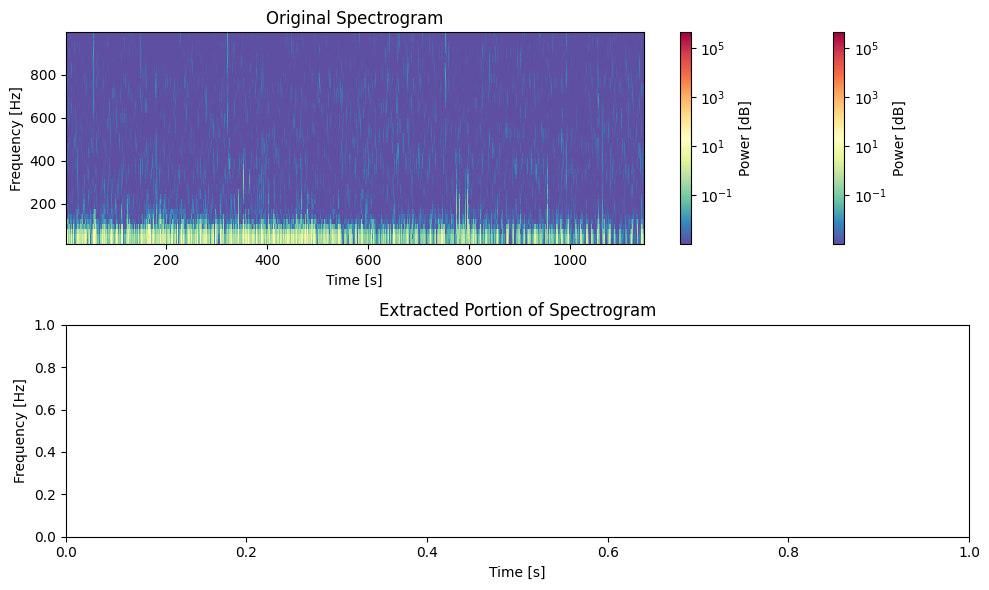

In [59]:
#Define time and frequency limits
time_start, time_end = 891, 897  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
time_indices = np.where((times >= time_start) & (times <= time_end))[0]

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print(spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
#plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()


I'm going to extract a single call now and check the size of the spectrogram array

Spectrogram size:  (25, 55)


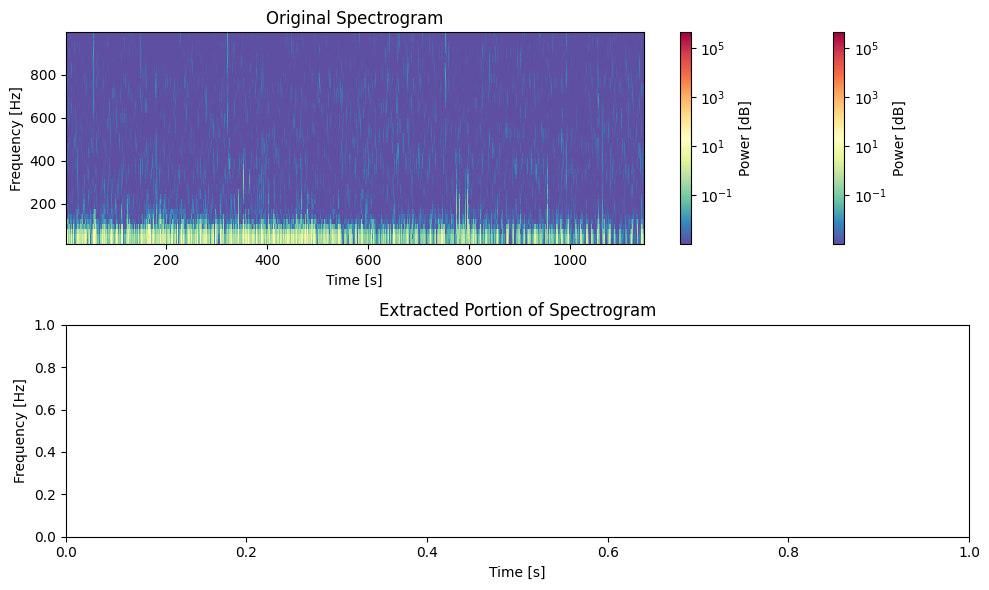

In [60]:
#Define time and frequency limits
time_start, time_end = 892.5, 893.2  # Time range in seconds
freq_start, freq_end = 20, 600  # Frequency range in Hz

#Find indices for the time range
time_indices = np.where((times >= time_start) & (times <= time_end))[0]

#Find indices for the frequency range
freq_indices = np.where((frequencies >= freq_start) & (frequencies <= freq_end))[0]

#Extract the portion of the spectrogram
spectrogram_sub = spectrogram[freq_indices][:, time_indices]
frequencies_sub = frequencies[freq_indices]
times_sub = times[time_indices]
print("Spectrogram size: ", spectrogram_sub.shape)

#Plot the original and sub-portion spectrograms
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.pcolormesh(times, frequencies, spectrogram, norm=LogNorm(), cmap='Spectral_r')
plt.title('Original Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.subplot(2, 1, 2)
#plt.pcolormesh(times_sub, frequencies_sub, spectrogram_sub, norm=LogNorm(), cmap='Spectral_r')
plt.title('Extracted Portion of Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar(label='Power [dB]')

plt.tight_layout()
plt.show()

Try and save the spectrogram plot. (I wouldn't actually do this in practice - I would save the extracted spectrogram as raw data to be used for ML)

In [61]:
plt.savefig('spectrogram.png')
#plt.clf()
print(spectrogram_sub)
print(spectrogram_sub.shape)

[[0.00185662 0.00211693 0.00199817 ... 0.0137269  0.0032082  0.001     ]
 [0.00342745 0.00436494 0.00209352 ... 0.02045808 0.00458667 0.001     ]
 [0.00429844 0.00431756 0.0018523  ... 0.0083609  0.00289356 0.001     ]
 ...
 [0.00218353 0.001      0.001      ... 0.001      0.001      0.001     ]
 [0.00227201 0.001      0.001      ... 0.001      0.001      0.001     ]
 [0.00265812 0.001      0.001      ... 0.001      0.001      0.001     ]]
(25, 55)


<Figure size 640x480 with 0 Axes>

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
model = LogisticRegression()

In [64]:
X = spectrogram_sub
y = df.Annotation[0:25]
#Reshape X before train_test_split to add a sample dimension
#X = X.reshape(-1, spectrogram_sub.shape[0], spectrogram_sub.shape[1])  # Reshape to (samples, 25, 55)

# Reshape X to have the correct number of samples
# Assuming you have 25 samples, each with 25x55 features
# If the number of samples is different, adjust the first dimension accordingly
#X = X.reshape(25, spectrogram_sub.shape[0], spectrogram_sub.shape[1])

#Now proceed with the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1138)

print(y)
numberofclasses = np.unique(y).size
print("numberofclasses: ", numberofclasses)

0      Rupe A
1      Rupe A
2      Rupe A
3      Rupe A
4      Rupe A
5      Rupe B
6      Rupe A
7      Rupe B
8      Rupe B
9      Rupe B
10     Rupe B
11     Rupe B
12     Rupe B
13     Rupe B
14     Rupe B
15     Rupe A
16     Rupe B
17     Rupe B
18     Rupe C
19     Rupe A
20     Rupe B
21     Rupe A
22    Growl B
23    Growl B
24     Rupe A
Name: Annotation, dtype: object
numberofclasses:  4


In [65]:
#X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1138)

In [66]:
model = tf.keras.models.Sequential()
#model.add(tf.keras.layers.Flatten(input_shape=(25, 0)))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(100,activation='relu'))
model.add(tf.keras.layers.Dense(numberofclasses))

In [67]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [68]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [69]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [70]:
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4286 - loss: 1.3867 - val_accuracy: 0.2500 - val_loss: 1.3852
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5000 - loss: 1.3825 - val_accuracy: 0.2500 - val_loss: 1.3836
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5000 - loss: 1.3778 - val_accuracy: 0.2500 - val_loss: 1.3819
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5000 - loss: 1.3730 - val_accuracy: 0.2500 - val_loss: 1.3800
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5000 - loss: 1.3678 - val_accuracy: 0.2500 - val_loss: 1.3780
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5000 - loss: 1.3623 - val_accuracy: 0.2500 - val_loss: 1.3760
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5000 - loss: 1.3564 - val_accuracy: 0.2500 - val_loss: 1.3738
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5000 - loss: 1.3502 - val_accuracy: 0.2500 - val_loss: 1.3714


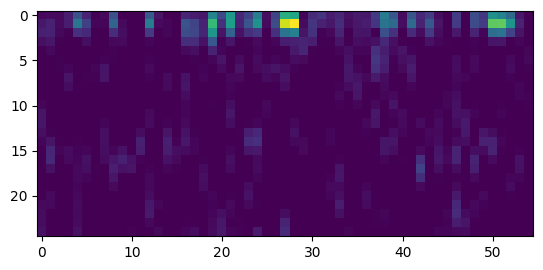

In [71]:
plt.imshow(spectrogram_sub)

In [72]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)

1/1 - 0s - 24ms/step - accuracy: 0.2857 - loss: 1.1992


In [73]:
print("Model accuracy = ", accuracy)

Model accuracy =  0.2857142984867096


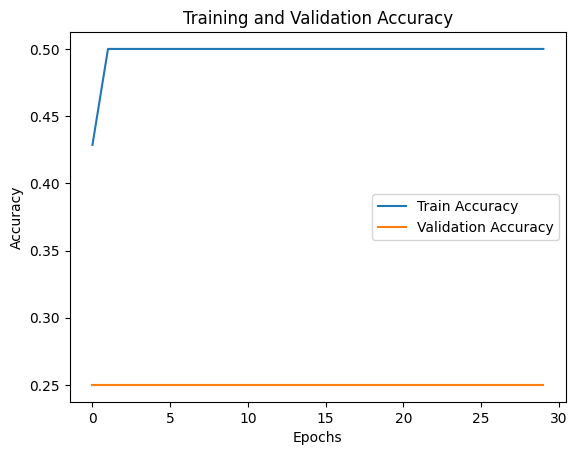

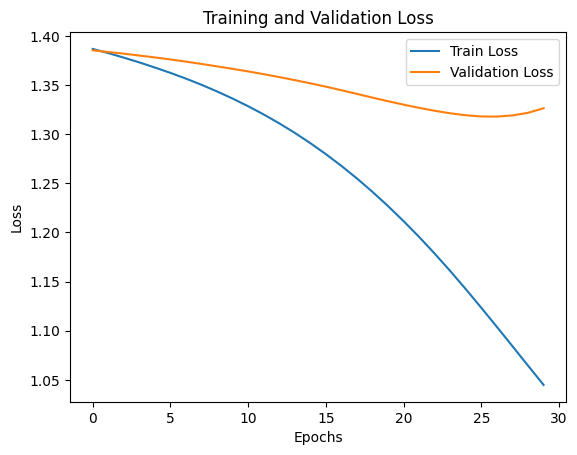

In [74]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()